<a href="https://colab.research.google.com/github/AhmadAkbariR/deepxde/blob/master/examples/operator/elasticity-2D-AAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# @ 2D elastic square domain --> PINN-DeepONet

"""Backend supported: tensorflow, pytorch, paddle"""

import os
os.environ['DDE_BACKEND'] = 'pytorch'
try:
   import deepxde as dde
except ImportError:
   !pip install deepxde

#import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
current_backend = dde.backend.backend_name
print("Current default backend is:", current_backend)

import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)



Current default backend is: pytorch
Using device: cpu


Compiling model...
'compile' took 0.000966 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [7.77e+00, 6.38e-01, 9.07e-01]    [1.79e+01, 1.93e+00, 1.00e+00]    []  
1000      [2.02e-03, 1.10e-03, 2.27e-03]    [1.35e-02, 4.83e-03, 8.14e-03]    []  
2000      [1.21e-03, 6.34e-04, 6.17e-04]    [9.16e-03, 2.90e-03, 4.35e-03]    []  
3000      [5.61e-04, 3.66e-04, 4.29e-04]    [4.10e-03, 1.99e-03, 2.95e-03]    []  

Best model at step 3000:
  train loss: 1.36e-03
  test loss: 9.03e-03
  test metric: []

'train' took 486.344232 s



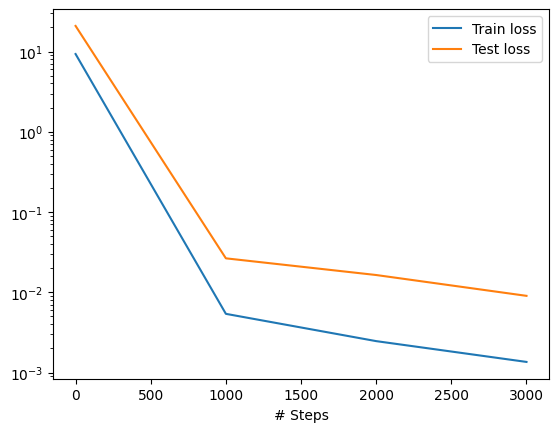

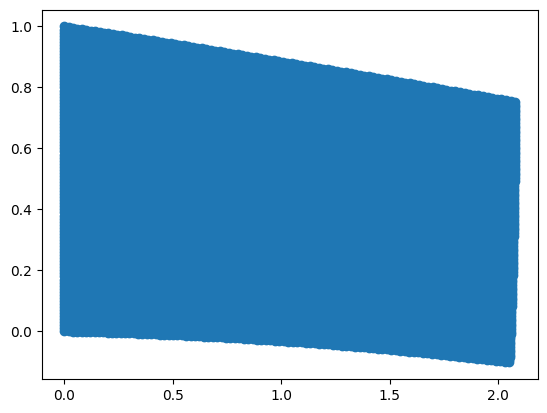

In [ ]:
# PDE equation
def pde(xy, uv, aux):
    mu = 0.01
    nu = 0.3
    u, v = uv[..., 0:1], uv[..., 1:2]
    #u, v, p = uvp[..., 0:1], uvp[..., 1:2], uvp[..., 2:3]
    grad_u = dde.zcs.LazyGrad(xy, u)
    grad_v = dde.zcs.LazyGrad(xy, v)
    #grad_p = dde.zcs.LazyGrad(xy, p)
    # first order
    du_x = grad_u.compute((1, 0))
    dv_y = grad_v.compute((0, 1))

    grad_du_x = dde.zcs.LazyGrad(xy, du_x)
    grad_dv_y = dde.zcs.LazyGrad(xy, dv_y)

    #dp_x = grad_p.compute((1, 0))
    #dp_y = grad_p.compute((0, 1))
    # second order
    du_xx = grad_u.compute((2, 0))
    du_yy = grad_u.compute((0, 2))
    du_xy = grad_du_x.compute((0, 1))
    dv_xx = grad_v.compute((2, 0))
    dv_xy = grad_dv_y.compute((1, 0))
    dv_yy = grad_v.compute((0, 2))
    Del2U = du_xx + du_yy + (1)/(1-2*nu) * (du_xx + dv_xy)
    Del2V = dv_xx + dv_yy + (1)/(1-2*nu) * (du_xy + dv_yy)

    #motion_x = mu * (du_xx + du_yy) - dp_x
    #motion_y = mu * (dv_xx + dv_yy) - dp_y
    #mass = du_x + dv_y
    #return motion_x, motion_y, mass
    return Del2U, Del2V

# Geometry
geom = dde.geometry.Rectangle([0, 0], [1, 1])


# Boundary condition
# other boundary conditions will be enforced by output transform

# Dirichlet bc on the right edge- U direction
def bc_right_U_func(x, aux_var):

    return  dde.backend.as_tensor( 1.  )  # uniform U =1 displacement
bc_right_U = dde.icbc.DirichletBC(
                                    geom=geom,
                                    func=bc_right_U_func,
                                    on_boundary=lambda x, on_boundary: np.isclose(x[0], 1.),
                                    component= 0 ) # component = 0 means x direction

# Dirichlet bc on the right edge- V direction
# def bc_right_V_func(x, aux_var):

#    return  dde.backend.as_tensor( 0. )

#bc_right_V = dde.icbc.DirichletBC(
#                                    geom=geom,
#                                    func=bc_right_V_func,
#                                    on_boundary=lambda x, on_boundary: np.isclose(x[0], 1.),
#                                    component= 1)

#def bc_slip_top_func(x, aux_var):
    # using (perturbation / 10 + 1) * x * (1 - x)
#    return (aux_var / 10 + 1.) * dde.backend.as_tensor(x[:, 0:1] * (1 - x[:, 0:1]))
#bc_slip_top = dde.icbc.DirichletBC(
#                                    geom=geom,
#                                    func=bc_slip_top_func,
#                                    on_boundary=lambda x, on_boundary: np.isclose(x[1], 1.),
#                                    component=0)
# PDE object
pde_obj = dde.data.PDE(
    geom,
    pde,
    bcs=[bc_right_U ],
    num_domain=500,
    num_boundary=50,  # sampling a bit more points on boundary (1000 on top bc)
    num_test=100,
)

# Function space
func_space = dde.data.GRF(length_scale=0.2)

# Data
n_pts_edge = 101  # using the size of true solution, but this is unnecessary
eval_pts = np.linspace(0, 1, num=n_pts_edge)[:, None]
data = dde.zcs.PDEOperatorCartesianProd(
    pde_obj, func_space, eval_pts, num_function=100,
    function_variables=[0], num_test=20, batch_size=10
)

# Net
net = dde.nn.DeepONetCartesianProd(
    [n_pts_edge, 50, 50, 50],
    [2, 50, 50, 50],
    "tanh",
    "Glorot normal",
    num_outputs=2,
    multi_output_strategy="independent"
)

# Output transform for zero boundary conditions
def out_transform(inputs, outputs):
    x, y = inputs[1][:, 0], inputs[1][:, 1]
    # horizontal displacement on left
    u = outputs[:, :, 0] * (x)[None, :]
    # vertical dis on left
    v = outputs[:, :, 1] * (x)[None, :]
    ## pressure on bottom
    #p = outputs[:, :, 2] * y[None, :]
    return dde.backend.stack((u, v), axis=2)
net.apply_output_transform(out_transform)

# Model
model = dde.zcs.Model(data, net)
model.compile("adam", lr=0.001, decay=("inverse time", 1000, 0.5))
losshistory, train_state = model.train(iterations=3000)
dde.utils.plot_loss_history(losshistory)
plt.show()

# save model if needed
# model.save('stokes_weights')

# Evaluation
func_feats = func_space.random(10)
v = func_space.eval_batch(func_feats, eval_pts)
v[:] = 0.  # true solution uses zero perturbation
xv, yv = np.meshgrid(eval_pts[:, 0], eval_pts[:, 0], indexing='ij')
xy = np.vstack((np.ravel(xv), np.ravel(yv))).T
sol_pred = model.predict((v, xy))[0]
#sol_true = np.load('../dataset/stokes.npz')['arr_0']
#print('Error on horizontal velocity:', dde.metrics.l2_relative_error(sol_true[:, 0], sol_pred[:, 0]))
#print('Error on vertical velocity:', dde.metrics.l2_relative_error(sol_true[:, 1], sol_pred[:, 1]))
#print('Error on pressure:', dde.metrics.l2_relative_error(sol_true[:, 2], sol_pred[:, 2]))
plt.figure(2)
def deform_coord(xy , sol_pred):
    return xy + sol_pred
deformed = deform_coord(xy , sol_pred)
plt.scatter(deformed[:,0],deformed[:,1])
plt.show()


In [ ]:
np.min(sol_pred[:,0])


NameError: name 'np' is not defined

In [ ]:
def Deformed_shape(xy, uv):
    x = xy[:,0]  # Original x coordinates
    y = xy[:,1]  # Original y coordinates
    u = uv[:,0]  # Random displacement in x direction
    v = uv[:,1]  # Random displacement in y direction


    # New coordinates after displacement

    x_new = x + u
    y_new = y + v

    # Plotting
    plt.figure(figsize=(12, 8))
    plt.quiver(x, y, u, v, angles='xy', scale_units='xy', scale=1, color='blue', alpha=0.5, label='Displacement (u, v)')
    plt.scatter(x, y, color='red', s=10, alpha=0.7, label='Original Nodes')
    plt.scatter(x_new, y_new, color='green', s=10, alpha=0.7, label='New Nodes')

    # Setting the limits for better visualization
    plt.xlim(-0.1, 2.1)  # Adjust the range based on your data
    plt.ylim(-0.1, 1.1)
    plt.grid()
    plt.axhline(0, color='grey', lw=0.5)
    plt.axvline(0, color='grey', lw=0.5)
    plt.title('Original and Displaced Nodes')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.show()

Deformed_shape(xy, sol_pred)

Compiling model...
'compile' took 0.000338 s

Training model...



RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.

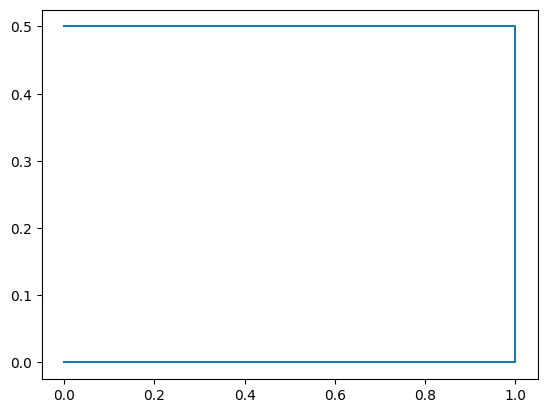

In [13]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt


# Define the PDE system

def pde_system(x , u):
    # Define the parameters
    nu = 0.3
    # Calculate the second derivatives of u and v
    u_xx = dde.grad.hessian(u, x, component=0, i = 0 , j = 0)
    u_yy = dde.grad.hessian(u, x, component=0, i = 1 , j = 1)
    u_xy = dde.grad.hessian(u, x, component=0, i = 0 , j = 1)

   # u_xy = dde.grad.hessian(u, [x, y])

   # v_xx = dde.grad.hessian(v, x)
   # v_yy = dde.grad.hessian(v, y)
   # v_xy = dde.grad.hessian(v, [x, y])
    v_xx = dde.grad.hessian(u, x, component=1, i = 0 , j = 0)
    v_yy = dde.grad.hessian(u, x, component=1, i = 1 , j = 1)
    v_xy = dde.grad.hessian(u, x, component=1, i = 0 , j = 1)
    # Define the equations
    eq1 = u_xx + u_yy + (1 / (1 - 2 * nu)) * (u_xx + v_xy)
    eq2 = v_xx + v_yy + (1 / (1 - 2 * nu)) * (v_yy + u_xy)

    return eq1, eq2

# Define the geometry
lx = 1
ly = 0.5

geom = dde.geometry.Rectangle(xmin=[0, 0], xmax=[lx, ly])

# Define the boundary condition functions
def boundary_left(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0)

def boundary_right(x, on_boundary):
    return on_boundary and np.isclose(x[0], lx)

def boundary_top(x, on_boundary):
    return on_boundary and np.isclose(x[1], ly)

def boundary_bottom(x, on_boundary):
    return on_boundary and np.isclose(x[1], 0)



# Define the boundary conditions using DirichletBC
bc1 = dde.DirichletBC(geom, lambda x: 0, boundary_left, component=0)    # u(x=0, y) = 0
bc2 = dde.DirichletBC(geom, lambda x: 0, boundary_left, component=1)    # v(x=0, y) = 0
bc3 = dde.DirichletBC(geom, lambda x: 1, boundary_right, component=0)  # u(x=1, y) = 1
bc4 = dde.DirichletBC(geom, lambda x: 0, boundary_bottom, component=1)  # v(x, y=0) = 0
#bc5 = dde.NeumannBC(geom, lambda x: 0, boundary_bottom, component=1)  #
#bc6 = dde.NeumannBC(geom, lambda x: 0, boundary_top, component=0)  #
#bc7 = dde.NeumannBC(geom, lambda x: 0, boundary_top, component=1)  #

# If you want both u and v to be zero at the boundary x = 0
# You can have something like:
# bc4 = dde.DirichletBC(geom, lambda x: 0, boundary_v_1)  # v(x=0, y) = 0
# Create a data object for the PDE
data = dde.data.PDE(geom, pde_system, [bc1, bc2, bc3, bc4], num_domain=10000, num_boundary=1000)

# Build the neural network with two hidden layers, each with 50 neurons
net = dde.nn.FNN([2] + [50] * 2 + [2], "tanh", "Glorot uniform")

# Create and compile the model
model = dde.Model(data, net)

# Compile the model with an optimizer (instead of learning_rate here)
model.compile("adam", lr=0.001)  # Note changing learning_rate to lr

from scipy.spatial import ConvexHull

def deform_coord(X_test, predictions):
    return X_test + predictions


# Function to plot the boundary
def plot_boundary(X, label):
    if len(X) >= 3:  # A minimum of 3 points is needed to form a boundary
        hull = ConvexHull(X)
        plt.plot(X[hull.vertices, 0], X[hull.vertices, 1], label=label)


X_test = geom.uniform_points(1028, True)

# Plot undeformed shape boundary
plot_boundary(X_test, 'Undeformed Shape')


# Train the model
for i in range(1):

    model.train(1000)

    # Get the predictions

    predictions = model.predict(X_test)

    # Separate predictions into u and v components if the output is a 2D array
    u_pred = predictions[:, 0]  # First column for u
    v_pred = predictions[:, 1]  # Second column for v

    # Deformed coordinates
    deformed = deform_coord(X_test, predictions)

    # Plotting
    plt.figure(1)

    # Plot deformed shape boundary
    plot_boundary(deformed, f'Deformed Shape {i}')

    # Scatter original and deformed points for visual reference
    #plt.scatter(X_test[:, 0], X_test[:, 1], color='blue', s=10, label='Undeformed Nodes')
    #plt.scatter(deformed[:, 0], deformed[:, 1], color='red', s=10, label='Deformed Nodes')

    plt.title('Undeformed and Deformed Shapes')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.axis('equal')  # To maintain aspect ratio
    plt.grid()





plt.figure()
def deform_coord(X_test , predictions):
    return X_test + predictions
deformed = deform_coord(X_test , predictions)
plt.scatter(deformed[:,0],deformed[:,1])
plt.show()

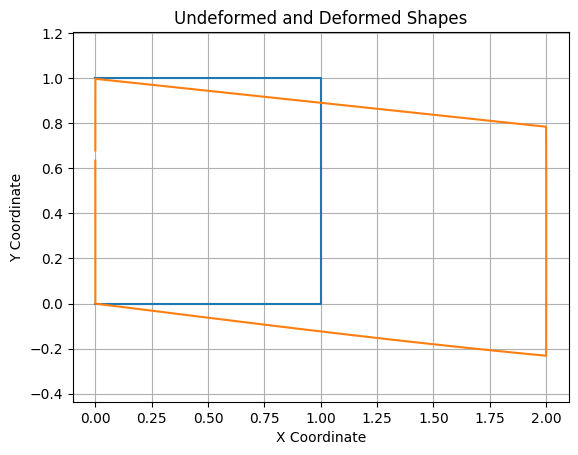

In [ ]:


# Deformed coordinates
deformed = deform_coord(X_test, predictions)

# Plotting
plt.figure()

# Function to plot the boundary
def plot_boundary(X, label):
    if len(X) >= 3:  # A minimum of 3 points is needed to form a boundary
        hull = ConvexHull(X)
        plt.plot(X[hull.vertices, 0], X[hull.vertices, 1], label=label)

# Plot undeformed shape boundary
plot_boundary(X_test, 'Undeformed Shape')

# Plot deformed shape boundary
plot_boundary(deformed, 'Deformed Shape')

# Scatter original and deformed points for visual reference
#plt.scatter(X_test[:, 0], X_test[:, 1], color='blue', s=10, label='Undeformed Nodes')
#plt.scatter(deformed[:, 0], deformed[:, 1], color='red', s=10, label='Deformed Nodes')

plt.title('Undeformed and Deformed Shapes')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
#plt.legend()
plt.axis('equal')  # To maintain aspect ratio
plt.grid()
plt.show()